In [321]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler


#### Step 2: Loading the Dataset

<AxesSubplot:>

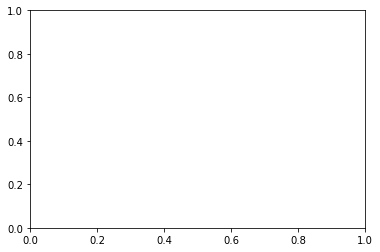

In [354]:
# Transforms images to a PyTorch Tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))]) #NOTE: change the range of the data from 0 to 1 TO -1 to 1.
  
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data", # The location of the downlode file
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(dataset = training_data, 
                              batch_size = batch_size,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size=batch_size,
                             shuffle = True)
plt.subplot()

In [273]:
print(type(train_dataloader.dataset))
for X, y in test_dataloader:
    print(f"Shape of X [Batch size, Channel, Height, Width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f'The maximum value is {torch.max(X)} and minimum value is {torch.min(X)}')
    break

<class 'torchvision.datasets.mnist.MNIST'>
Shape of X [Batch size, Channel, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
The maximum value is 1.0 and minimum value is -1.0


### Create Autoencoder Class

In [345]:
# Creating a PyTorch class
class AE_dense(torch.nn.Module):
    def __init__(self):
        super(AE_dense,self).__init__()
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = torch.nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 100 ==> 400
        self.decoder = torch.nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

In [330]:
class Reshape(nn.Module):
    def __init__(self,shape):
        super(Reshape,self).__init__()
        self.shape = shape
    
    def forward(self, x):
        return x.view(*self.shape) #NOTE: '*' passes multiple parameters(but here with or without * returns the same value)
        

# Creating a PyTorch class
class AE_conv(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AE_conv,self).__init__()
        # Building a convolution encoder with convolutional
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride = 2, padding=1), # 28 * 28 -> 14 * 14
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1), # 14 * 14 -> 7 * 7
            nn.LeakyReLU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(7*7*64, latent_dim), # second argument: latent_dim
            nn.LeakyReLU()
        )
          
        # Building an convolution decoder with convolutional
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,7*7*64),
            nn.LeakyReLU(),
            Reshape((-1,64,7,7)),
            nn.ConvTranspose2d(64,32,2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,1,2, stride=2),
            nn.Sigmoid())
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

### Initializing models

In [348]:
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Model Initialization
model = AE_dense().to(device)
  
# Validation using MSE Loss function
loss_fn = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2,
                             weight_decay = 1e-8)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1,patience=1,mode='min')
summary(model, (1, 28*28))


Using cpu device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              ReLU-6                [-1, 1, 12]               0
            Linear-7                 [-1, 1, 3]              39
            Linear-8                [-1, 1, 12]              48
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             ReLU-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14  

### Define training function 

In [357]:
def show(dataloader, model, epoch, num):
    '''Plot the original and reconstructed images together

    Args:
        dataloader (data_loader): an object that wraps the dataset
        model (model): autoencoder
        num (int): the number of samples to be plotted
    '''
    model.eval() #Tell the model you are going to test so the weights will not be updated
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X = X.view(X.size(0), -1)
            X, y = X.to(device), y.to(device) # to is one of the operations(methods) in tensor object
            
            pred = model(X)
            reconstructed = pred[0].reshape(-1,28,28)
            print(reconstructed.shape)
            X = X.reshape(-1,28,28)
            print(X.shape)
            
            # plot part
            fig, axs = plt.subplots(2,num, figsize=(20,5)) # 2 means two rows
            for j in range(num):
                # display the original image
                axs[0][j].imshow(X[j]) ##Note axs is a matrix, you can't just write axs[], it should be axs[][]
                # display the reconstructed image
                axs[1][j].imshow(reconstructed[j])

            plt.savefig(f'epoch-{epoch}.png')
            break
            

In [358]:
def train(epochs, dataloader, testdata,model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset) # return the number of training samples
    model.train() #Tell the model you are going to train so the weights will be updated
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader): # iterates the dataloader 
            X = X.view(X.size(0),-1)
            
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X) #! NOTE: Here the returned value is a tuple (decoded, encoded) as defined in forward()
            loss = loss_fn(pred[0], X) # Choose the first value pred[0] as decoded value for the purpose of training
                                        #! NOTE: the second argument should be the original value
            # Backpropagation
            optimizer.zero_grad() # to reset the gradients of model parameters.
            loss.backward() # PyTorch deposits the gradients of the loss w.r.t. each parameter.
            optimizer.step() # to adjust the parameters by the gradients collected in the backward pass.

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        scheduler.step(loss)
        show(testdata, model, t,10)
        print('Epoch: {}, Loss: {}, LR: {}'.format(t, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

###  Start training and validating

Epoch 1
-------------------------------
loss: 0.057025  [    0/60000]
loss: 0.056928  [ 6400/60000]
loss: 0.056898  [12800/60000]
loss: 0.056865  [19200/60000]
loss: 0.056874  [25600/60000]
loss: 0.062280  [32000/60000]
loss: 0.057803  [38400/60000]
loss: 0.058229  [44800/60000]
loss: 0.057417  [51200/60000]
loss: 0.058066  [57600/60000]
torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
Epoch: 0, Loss: 0.06272720545530319, LR: 1.0000000000000002e-06
Epoch 2
-------------------------------
loss: 0.057313  [    0/60000]
loss: 0.060004  [ 6400/60000]
loss: 0.056813  [12800/60000]
loss: 0.059389  [19200/60000]
loss: 0.061414  [25600/60000]
loss: 0.059389  [32000/60000]
loss: 0.057850  [38400/60000]
loss: 0.058455  [44800/60000]
loss: 0.059215  [51200/60000]
loss: 0.055385  [57600/60000]
torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
Epoch: 1, Loss: 0.054457325488328934, LR: 1.0000000000000002e-06
Epoch 3
-------------------------------
loss: 0.059658  [    0/60000]
loss: 0.053023  [ 640

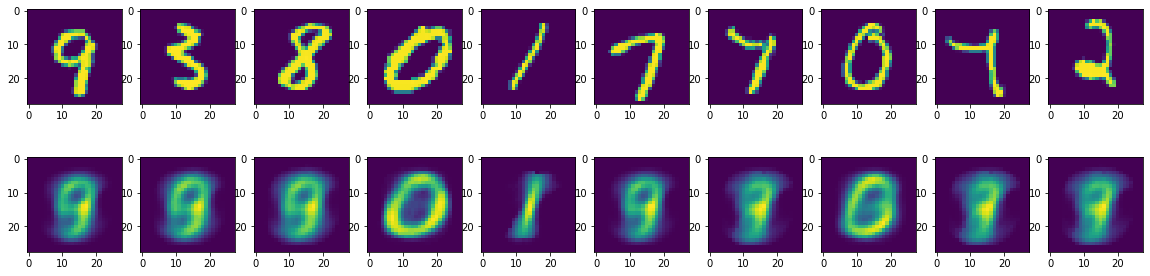

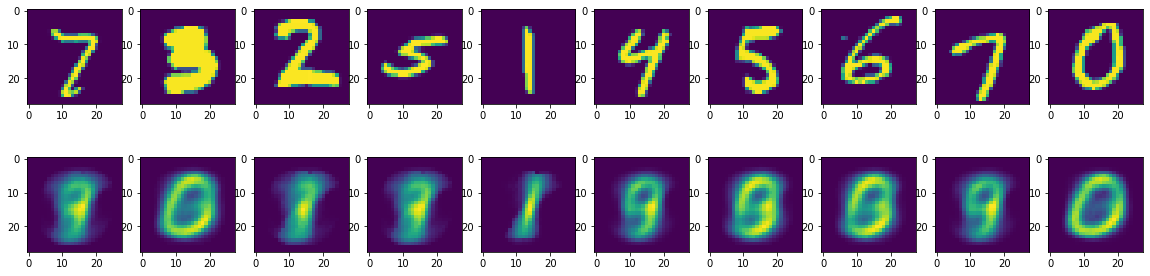

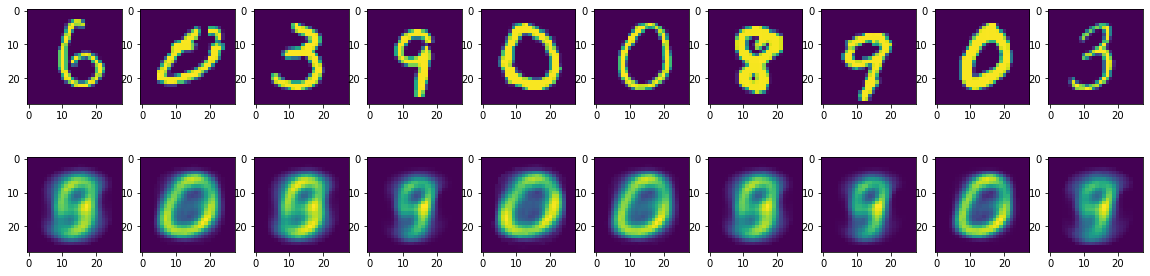

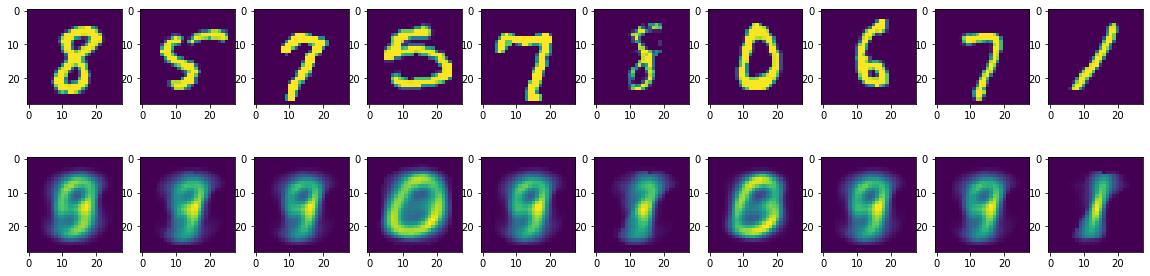

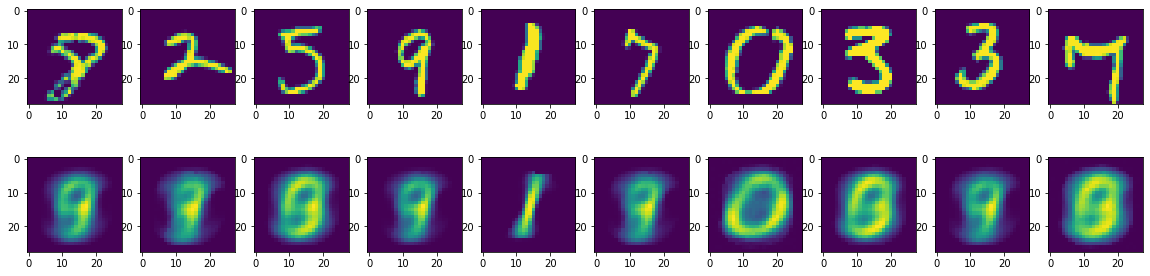

In [359]:
epochs = 5
train(epochs, train_dataloader,test_dataloader, model, loss_fn, optimizer,scheduler)
print("Done!")

###  Input/Reconstructed Input to/from Autoencoder

torch.Size([64, 28, 28])
torch.Size([64, 28, 28])


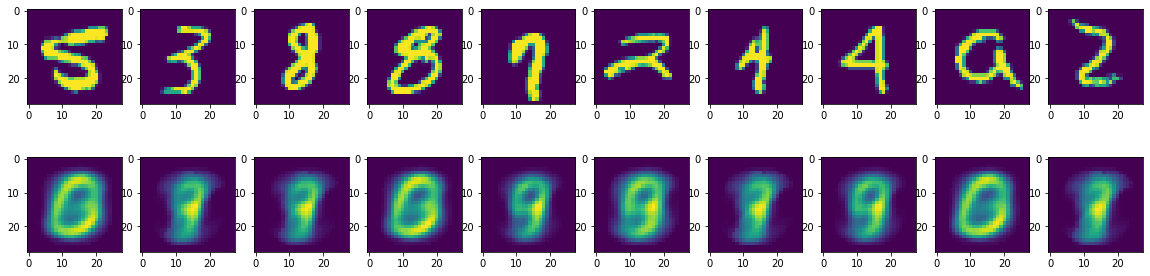

In [356]:
show(test_dataloader,model,10)